In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import gridspec
import logomaker as lm
from Bio import SeqIO
import bioframe
from scipy.stats import fisher_exact, pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

In [4]:
def read_variants(sample):
    variants = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/{sample}.phased.het.bed', 
                           sep = '\t', header = None)
    variants[11] = [int(x.split('|')[0]) for x in variants[10].values]
    variants[12] = [int(x.split('|')[1].split(':')[0]) for x in variants[10].values]
    variants = variants[[0, 2, 2, 3, 5, 6, 11, 12]]
    variants.columns = ['chrom', 'start', 'end', 'variant_id', 'ref', 'alt', 'allele_ref', 'allele_alt']
    return(variants)

def read_asocr_peaks(sample):
    asocr_peaks = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_allele_specific.bed', sep = '\t', header = None)
    asocr_peaks.columns = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR']
    return(asocr_peaks[['chrom', 'start', 'end', 'peak_id', 'log2FoldChange', 'FDR']])

def read_balanced_peaks(sample):
    balanced_peaks = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_balanced.bed', sep = '\t', header = None)
    balanced_peaks.columns = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR']
    return(balanced_peaks[['chrom', 'start', 'end', 'peak_id', 'log2FoldChange', 'FDR']])

def get_variants_for_peaks(phased_variants, peaks):
    peaks = peaks[peaks['chrom'] != 'chrX']
    phased_variants_overlap_peaks = bioframe.overlap(phased_variants, peaks, suffixes = ('', '_peak'))
    phased_variants_overlap_peaks = phased_variants_overlap_peaks.dropna()

    putative_non_overlaps = peaks[~peaks['peak_id'].isin(phased_variants_overlap_peaks['peak_id_peak'])]['peak_id'].values
    if len(putative_non_overlaps) != 0:
        peaks_non_overlaps = peaks[peaks['peak_id'].isin(putative_non_overlaps)]

        phased_variants_overlap_non_overlaps = bioframe.closest(peaks_non_overlaps, phased_variants, suffixes = ('_peak', ''))
        sort_order = list(phased_variants_overlap_non_overlaps.columns[5:]) + list(phased_variants_overlap_non_overlaps.columns[:5])
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps[sort_order]
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps.drop('distance', axis = 1)

    phased_variants_overlap_peaks = pd.concat([phased_variants_overlap_peaks, phased_variants_overlap_non_overlaps], ignore_index = True)
    phased_variants_overlap_peaks = phased_variants_overlap_peaks.sort_values(['chrom', 'start'])
    phased_variants_overlap_peaks.index = np.arange(len(phased_variants_overlap_peaks))
    return(phased_variants_overlap_peaks)

## Merge annotated batches of variants

In [5]:
## Variants annotations from all samples
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    for variants_type in ['asocr', 'balanced']:
        files = os.listdir('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/batches')
        files = sorted([x for x in files if sample in x and variants_type in x and 'batch' in x and 'peak' not in x])

        annotated_variants = []
        for table in files:
            annotated_variants.append(pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/batches/{table}', sep = '\t', header = 0))
        annotated_variants = pd.concat(annotated_variants)

        annotated_variants.to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_{variants_type}.txt', header = 1, index = 0, sep = '\t')

## Peaks annotation from NA12878
#files = os.listdir('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/batches')
#files = sorted([x for x in files if sample in x and 'asocr' in x and 'batch' in x and 'peak' in x])

#annotated_peaks = []
#for table in files:
#    annotated_peaks.append(pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/batches/{table}', sep = '\t', header = 0))
#annotated_peaks = pd.concat(annotated_peaks)

#annotated_peaks.to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/NA12878_peaks_annotation_asocr.txt', header = 1, index = 0, sep = '\t')

## Correlation between measured accessibility and contribution scores difference

In [54]:
v_as_total, v_bal_total = {}, {}

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:

    # Read phased variants coordinates in hg38 and exclude chrX from analyses
    phased_variants = read_variants(sample)
    phased_variants = phased_variants[phased_variants['chrom'] != 'chrX']

    # Read allele-specific and balanced accessibility peaks
    asocr_peaks = read_asocr_peaks(sample)
    balanced_peaks = read_balanced_peaks(sample)

    # Overlap phased variants with allele-specific peaks
    phased_variants_overlap_asocr = get_variants_for_peaks(phased_variants, asocr_peaks)

    # Overlap phased variants with balanced peaks
    phased_variants_overlap_balanced = get_variants_for_peaks(phased_variants, balanced_peaks)

    variants_annotation_as = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_asocr.txt', sep = '\t')
    variants_annotation_as = variants_annotation_as.merge(phased_variants_overlap_asocr.drop('start', axis = 1), on = ['chrom', 'variant_id'])
    variants_annotation_as = variants_annotation_as[['variant_id', 'peak_id_peak', 'log2FoldChange_peak', 'delta_cs_flank']].dropna()

    variants_annotation_balanced = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_balanced.txt', sep = '\t')
    variants_annotation_balanced = variants_annotation_balanced.merge(phased_variants_overlap_balanced.drop('start', axis = 1), on = ['chrom', 'variant_id'])
    variants_annotation_balanced = variants_annotation_balanced[['variant_id', 'peak_id_peak', 'log2FoldChange_peak', 'delta_cs_flank']].dropna()

    v_as_total[sample] = variants_annotation_as
    v_bal_total[sample] = variants_annotation_balanced
    
variants_annotation_as = pd.concat([v_as_total['NA12878'], v_as_total['NA18983'], v_as_total['HG01241'], v_as_total['HG02601'], v_as_total['HG03464']])
variants_annotation_balanced = pd.concat([v_bal_total['NA12878'], v_bal_total['NA18983'], v_bal_total['HG01241'], v_bal_total['HG02601'], v_bal_total['HG03464']])

In [55]:
print('Pearson allele-specific:', pearsonr(variants_annotation_as['log2FoldChange_peak'], variants_annotation_as['delta_cs_flank'])[0])
print('Pearson balanced:', pearsonr(variants_annotation_balanced['log2FoldChange_peak'], variants_annotation_balanced['delta_cs_flank'])[0])

Pearson allele-specific: 0.2991784814056219
Pearson balanced: 0.097188238130349


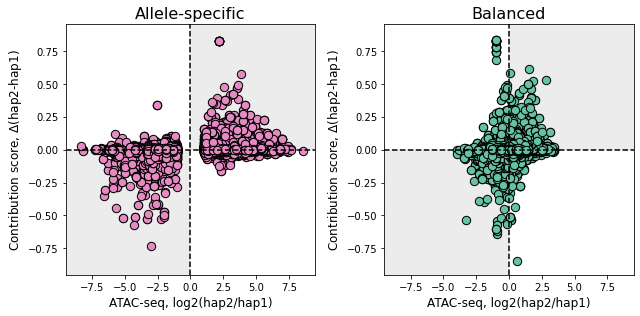

In [57]:
plt.figure(figsize = (9, 4.5))

plt.subplot(121)
plt.title(f'Allele-specific', fontsize = 16)
plt.scatter(variants_annotation_as['log2FoldChange_peak'], variants_annotation_as['delta_cs_flank'],
            color = '#E68AC3', edgecolor = 'k', s = 70)
plt.axhline(0, color = 'k', ls = '--')
plt.axvline(0, color = 'k', ls = '--')
plt.fill_between([-10, 0], -1, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.fill_between([0, 10], 0, 1, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.xlim((-9.5, 9.5))
plt.ylim((-0.95, 0.95))
plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
plt.ylabel('Contribution score, $\Delta$(hap2-hap1)', fontsize = 12)

plt.subplot(122)
plt.title(f'Balanced', fontsize = 16)
plt.scatter(variants_annotation_balanced['log2FoldChange_peak'], variants_annotation_balanced['delta_cs_flank'],
            color = '#66C2A5', edgecolor = 'k', s = 70)
plt.axhline(0, color = 'k', ls = '--')
plt.axvline(0, color = 'k', ls = '--')
plt.fill_between([-10, 0], -1, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.fill_between([0, 10], 0, 1, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.xlim((-9.5, 9.5))
plt.ylim((-0.95, 0.95))
plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
plt.ylabel('Contribution score, $\Delta$(hap2-hap1)', fontsize = 12)

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/chrombpnet_scatter_atacseq_cs_merged.pdf', bbox_inches = 'tight')
plt.show()

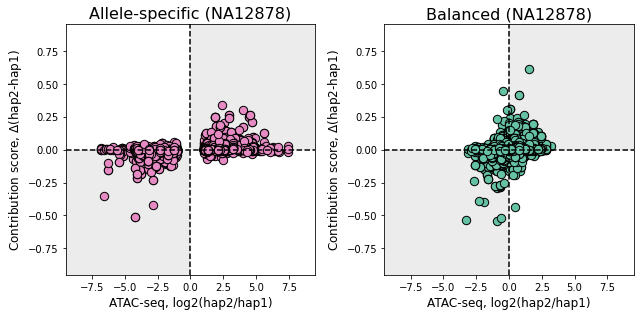

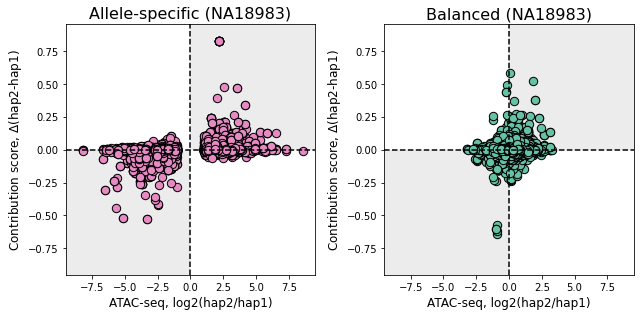

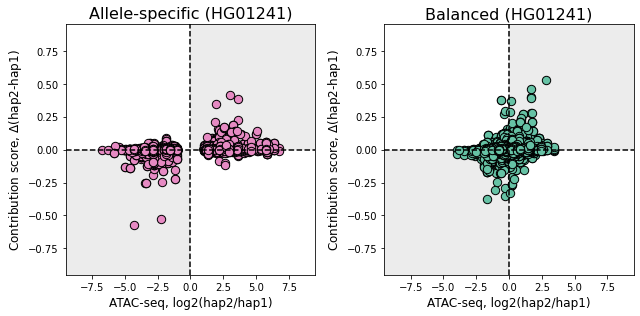

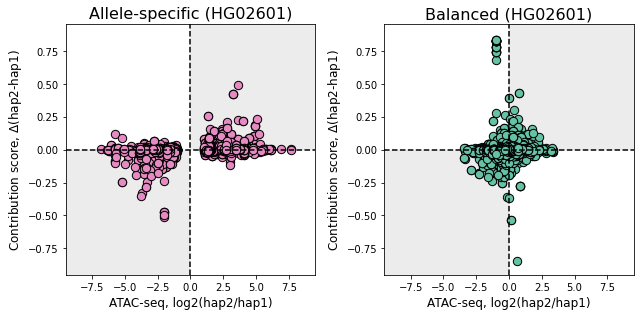

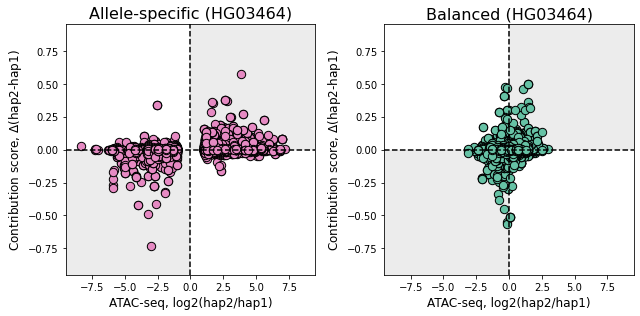

In [58]:
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:

    # Read phased variants coordinates in hg38 and exclude chrX from analyses
    phased_variants = read_variants(sample)
    phased_variants = phased_variants[phased_variants['chrom'] != 'chrX']

    # Read allele-specific and balanced accessibility peaks
    asocr_peaks = read_asocr_peaks(sample)
    balanced_peaks = read_balanced_peaks(sample)

    # Overlap phased variants with allele-specific peaks
    phased_variants_overlap_asocr = get_variants_for_peaks(phased_variants, asocr_peaks)

    # Overlap phased variants with balanced peaks
    phased_variants_overlap_balanced = get_variants_for_peaks(phased_variants, balanced_peaks)

    variants_annotation_as = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_asocr.txt', sep = '\t')
    variants_annotation_as = variants_annotation_as.merge(phased_variants_overlap_asocr.drop('start', axis = 1), on = ['chrom', 'variant_id'])
    variants_annotation_as = variants_annotation_as[['variant_id', 'peak_id_peak', 'log2FoldChange_peak', 'delta_cs_flank']].dropna()

    variants_annotation_balanced = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_balanced.txt', sep = '\t')
    variants_annotation_balanced = variants_annotation_balanced.merge(phased_variants_overlap_balanced.drop('start', axis = 1), on = ['chrom', 'variant_id'])
    variants_annotation_balanced = variants_annotation_balanced[['variant_id', 'peak_id_peak', 'log2FoldChange_peak', 'delta_cs_flank']].dropna()

    plt.figure(figsize = (9, 4.5))

    plt.subplot(121)
    plt.title(f'Allele-specific ({sample})', fontsize = 16)
    plt.scatter(variants_annotation_as['log2FoldChange_peak'], variants_annotation_as['delta_cs_flank'],
                color = '#E68AC3', edgecolor = 'k', s = 70,
                label = f"r={round(pearsonr(variants_annotation_as['log2FoldChange_peak'], variants_annotation_as['delta_cs_flank'])[0], 2)}")

    plt.axhline(0, color = 'k', ls = '--')
    plt.axvline(0, color = 'k', ls = '--')
    plt.fill_between([-10, 0], -1, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.fill_between([0, 10], 0, 1, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.xlim((-9.5, 9.5))
    plt.ylim((-0.95, 0.95))
    plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
    plt.ylabel('Contribution score, $\Delta$(hap2-hap1)', fontsize = 12)


    plt.subplot(122)
    plt.title(f'Balanced ({sample})', fontsize = 16)

    plt.scatter(variants_annotation_balanced['log2FoldChange_peak'], variants_annotation_balanced['delta_cs_flank'],
                color = '#66C2A5', edgecolor = 'k', s = 70,
                label = f"r={round(pearsonr(variants_annotation_balanced['log2FoldChange_peak'], variants_annotation_balanced['delta_cs_flank'])[0], 2)}")

    plt.axhline(0, color = 'k', ls = '--')
    plt.axvline(0, color = 'k', ls = '--')
    plt.fill_between([-10, 0], -1, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.fill_between([0, 10], 0, 1, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.xlim((-9.5, 9.5))
    plt.ylim((-0.95, 0.95))
    plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
    plt.ylabel('Contribution score, $\Delta$(hap2-hap1)', fontsize = 12)

    plt.tight_layout()
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/figures/chrombpnet_scatter_atacseq_cs_{sample}.pdf', bbox_inches = 'tight')
    plt.show()

## Selecting cutoff for contribution score difference

0.0 0.836 0.72
0.01 0.519 0.222
0.02 0.371 0.099
0.03 0.277 0.053
0.04 0.211 0.033
0.05 0.169 0.023
0.06 0.142 0.016
0.07 0.112 0.012
0.08 0.086 0.01
0.09 0.07 0.007
0.1 0.059 0.006


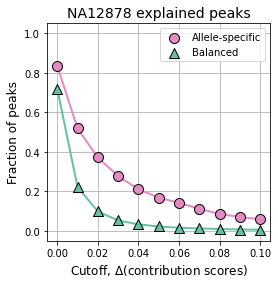

0.0 0.812 0.715
0.01 0.505 0.243
0.02 0.366 0.11
0.03 0.289 0.063
0.04 0.23 0.039
0.05 0.19 0.027
0.06 0.159 0.018
0.07 0.134 0.013
0.08 0.112 0.009
0.09 0.098 0.007
0.1 0.079 0.005


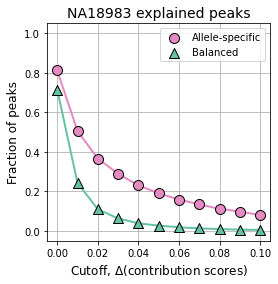

0.0 0.852 0.735
0.01 0.471 0.193
0.02 0.334 0.083
0.03 0.268 0.045
0.04 0.207 0.028
0.05 0.159 0.018
0.06 0.139 0.012
0.07 0.12 0.009
0.08 0.096 0.007
0.09 0.084 0.005
0.1 0.07 0.004


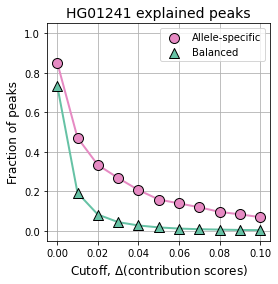

0.0 0.834 0.735
0.01 0.485 0.225
0.02 0.345 0.097
0.03 0.26 0.054
0.04 0.207 0.034
0.05 0.162 0.023
0.06 0.132 0.016
0.07 0.115 0.013
0.08 0.103 0.01
0.09 0.088 0.008
0.1 0.073 0.006


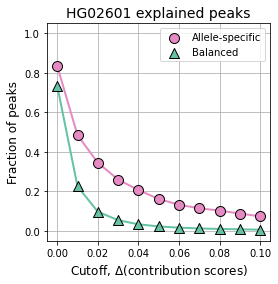

0.0 0.855 0.739
0.01 0.485 0.213
0.02 0.332 0.092
0.03 0.248 0.049
0.04 0.194 0.029
0.05 0.155 0.019
0.06 0.126 0.014
0.07 0.1 0.01
0.08 0.081 0.008
0.09 0.065 0.006
0.1 0.054 0.005


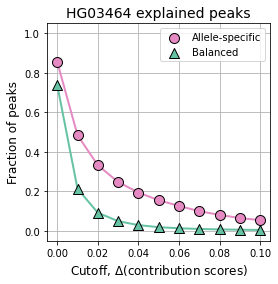

In [24]:
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:

    # Read phased variants coordinates in hg38 and exclude chrX from analyses
    phased_variants = read_variants(sample)
    phased_variants = phased_variants[phased_variants['chrom'] != 'chrX']

    # Read allele-specific and balanced accessibility peaks
    asocr_peaks = read_asocr_peaks(sample)
    balanced_peaks = read_balanced_peaks(sample)

    # Overlap phased variants with allele-specific peaks
    phased_variants_overlap_asocr = get_variants_for_peaks(phased_variants, asocr_peaks)

    # Overlap phased variants with balanced peaks
    phased_variants_overlap_balanced = get_variants_for_peaks(phased_variants, balanced_peaks)

    variants_annotation_as = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_asocr.txt', sep = '\t')
    variants_annotation_as = variants_annotation_as.merge(phased_variants_overlap_asocr.drop('start', axis = 1), on = ['chrom', 'variant_id'])

    variants_annotation_balanced = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_balanced.txt', sep = '\t')
    variants_annotation_balanced = variants_annotation_balanced.merge(phased_variants_overlap_balanced.drop('start', axis = 1), on = ['chrom', 'variant_id'])

    # Quantify explained peaks at different cutoffs
    explained_peaks_fractions_as, explained_peaks_fractions_balanced = [], []
    cutoffs = np.arange(0, 0.11, 0.01)

    for cutoff in cutoffs:
        explained_peaks_as = len(np.unique(variants_annotation_as[(abs(variants_annotation_as['delta_cs_flank']) > cutoff) &\
                                                                  (variants_annotation_as['delta_cs_flank']*variants_annotation_as['log2FoldChange_peak'] > 0)]['peak_id_peak']))
        total_peaks_as = len(np.unique(variants_annotation_as['peak_id_peak']))
        explained_peaks_fractions_as.append(explained_peaks_as/total_peaks_as)
        
        explained_peaks_balanced = len(np.unique(variants_annotation_balanced[(abs(variants_annotation_balanced['delta_cs_flank']) > cutoff) &\
                                                                              (variants_annotation_balanced['delta_cs_flank']*variants_annotation_balanced['log2FoldChange_peak'] > 0)]['peak_id_peak']))
        total_peaks_balanced = len(np.unique(variants_annotation_balanced['peak_id_peak']))
        explained_peaks_fractions_balanced.append(explained_peaks_balanced/total_peaks_balanced)

        print(cutoff, round(explained_peaks_as/total_peaks_as, 3), round(explained_peaks_balanced/total_peaks_balanced, 3))

    plt.figure(figsize = (4, 4))
    plt.title(sample + ' explained peaks', fontsize = 14)
    plt.plot(cutoffs, explained_peaks_fractions_as, color = '#E68AC3', lw = 2)
    plt.plot(cutoffs, explained_peaks_fractions_balanced, color = '#66C2A5', lw = 2)
    plt.scatter(cutoffs, explained_peaks_fractions_as, color = '#E68AC3', edgecolor = 'k', s = 100, label = 'Allele-specific', zorder = 10)
    plt.scatter(cutoffs, explained_peaks_fractions_balanced, color = '#66C2A5', marker = '^', edgecolor = 'k', s = 100, label = 'Balanced', zorder = 10)
    plt.xlabel('Cutoff, $\Delta$(contribution scores)', fontsize = 12)
    plt.ylabel('Fraction of peaks', fontsize = 12)
    plt.ylim((-0.05, 1.05))
    plt.grid(zorder = 0)
    plt.legend()
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/figures/chrombpnet_explained_peaks_{sample}.pdf', bbox_inches = 'tight')
    plt.show()

## Annotate groups of disrupted motifs using contribution scores for NA12878

In [8]:
sample = 'NA12878'

# Read phased variants coordinates in hg38 and exclude chrX from analyses
phased_variants = read_variants(sample)
phased_variants = phased_variants[phased_variants['chrom'] != 'chrX']

# Read allele-specific and balanced accessibility peaks
asocr_peaks = read_asocr_peaks(sample)
balanced_peaks = read_balanced_peaks(sample)

# Overlap phased variants with allele-specific peaks
phased_variants_overlap_asocr = get_variants_for_peaks(phased_variants, asocr_peaks)

# Overlap phased variants with balanced peaks
phased_variants_overlap_balanced = get_variants_for_peaks(phased_variants, balanced_peaks)

In [9]:
variants_annotation_as = pd.read_csv('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/NA12878_variants_annotation_asocr.txt', sep = '\t')
variants_annotation_as = variants_annotation_as.merge(phased_variants_overlap_asocr.drop('start', axis = 1), on = ['chrom', 'variant_id'])
variants_annotation_as.head()

,chrom,start,variant_id,pattern_id,is_rc,rank,relative_pos_start,pattern_length,r_hap1,r_hap2,...,ref,alt,allele_ref,allele_alt,chrom_peak,start_peak,end_peak,peak_id_peak,log2FoldChange_peak,FDR_peak
0,chr1,828014,1:828014:G:A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,G,A,0,1,chr1,826832,828040,NA12878_peak_2,6.379673,0.000012
1,chr1,1038800,1:1038800:G:T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,G,T,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369
2,chr1,1038819,1:1038819:C:T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,C,T,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369
3,chr1,1038845,1:1038845:A:G,EGR1,0.0,1.0,-8.0,9.0,-0.192225,0.806857,...,A,G,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369
4,chr1,1038845,1:1038845:A:G,SP,0.0,2.0,-7.0,11.0,-0.115942,0.789787,...,A,G,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369


In [10]:
variants_annotation_balanced = pd.read_csv('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/NA12878_variants_annotation_balanced.txt', sep = '\t')
variants_annotation_balanced = variants_annotation_balanced.merge(phased_variants_overlap_balanced.drop('start', axis = 1), on = ['chrom', 'variant_id'])
variants_annotation_balanced.head()

,chrom,start,variant_id,pattern_id,is_rc,rank,relative_pos_start,pattern_length,r_hap1,r_hap2,...,ref,alt,allele_ref,allele_alt,chrom_peak,start_peak,end_peak,peak_id_peak,log2FoldChange_peak,FDR_peak
0,chr1,984039,1:984039:T:C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,T,C,0,1,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716
1,chr1,984109,1:984109:C:T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,C,T,0,1,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716
2,chr1,984145,1:984145:TAGTC:T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TAGTC,T,0,1,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716
3,chr1,984475,1:984475:G:A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,G,A,1,0,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716
4,chr1,999842,1:999842:C:A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,C,A,0,1,chr1,999622,1001164,NA12878_peak_15,0.773273,0.496534


### Motif hits in allele-specific peaks

In [74]:
patterns = os.listdir('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/tf_modisco_pwms/')
patterns = sorted([x.split('.')[0].replace("/", "-") for x in patterns if 'pfm' in x])
patterns = np.unique([x.split('_')[0] if '_' in x else x for x in patterns])

for pattern in patterns:
    motif_patterns = variants_annotation_as[(variants_annotation_as['log2FoldChange_peak']*variants_annotation_as['delta_cs_flank'] > 0) &\
                                            (variants_annotation_as['log2FoldChange_peak']*variants_annotation_as['delta_cs'] > 0) &\
                                            (abs(variants_annotation_as['delta_cs_flank']) > 0.02) & (variants_annotation_as['rank'] == 1) &\
                                            (variants_annotation_as['pattern_id'].isin([x for x in variants_annotation_as['pattern_id'] if pattern in str(x)]))]
    motif_patterns_hap1 = motif_patterns[motif_patterns['log2FoldChange_peak'] < 0]
    motif_patterns_hap2 = motif_patterns[motif_patterns['log2FoldChange_peak'] > 0]
    
    if len(motif_patterns_hap1) != 0 and len(motif_patterns_hap2) != 0:
        print(f"{pattern}: {len(motif_patterns.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates())}, {len(motif_patterns_hap1.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates())} hap1 and {len(motif_patterns_hap2.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates())} hap2")
        motif_patterns_hap1.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_as.bed', sep = '\t', header = 0, index = 0)
        motif_patterns_hap2.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_as.bed', sep = '\t', header = 0, index = 0)

AP1: 39, 16 hap1 and 23 hap2
CRE: 7, 4 hap1 and 3 hap2
CTCF: 12, 5 hap1 and 7 hap2
EBF: 6, 5 hap1 and 1 hap2
EBOX: 7, 3 hap1 and 4 hap2
EGR1: 8, 3 hap1 and 5 hap2
ETS: 35, 20 hap1 and 15 hap2
IRF: 37, 16 hap1 and 21 hap2
NFI: 3, 2 hap1 and 1 hap2
NFKB: 25, 9 hap1 and 16 hap2
OCT: 3, 1 hap1 and 2 hap2
RUNX: 39, 23 hap1 and 16 hap2
SP: 10, 4 hap1 and 6 hap2


### Motif hits in balanced peaks

In [75]:
patterns = os.listdir('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/tf_modisco_pwms/')
patterns = sorted([x.split('.')[0].replace("/", "-") for x in patterns if 'pfm' in x])
patterns = np.unique([x.split('_')[0] if '_' in x else x for x in patterns])

for pattern in patterns:
    motif_patterns = variants_annotation_balanced[(variants_annotation_balanced['log2FoldChange_peak']*variants_annotation_balanced['delta_cs_flank'] > 0) &\
                                                  (variants_annotation_balanced['log2FoldChange_peak']*variants_annotation_balanced['delta_cs'] > 0) &\
                                                  (abs(variants_annotation_balanced['delta_cs_flank']) > 0.02) & (variants_annotation_balanced['rank'] == 1) &\
                                                  (variants_annotation_balanced['pattern_id'].isin([x for x in variants_annotation_balanced['pattern_id'] if pattern in str(x)]))]
    motif_patterns_hap1 = motif_patterns[motif_patterns['log2FoldChange_peak'] < 0]
    motif_patterns_hap2 = motif_patterns[motif_patterns['log2FoldChange_peak'] > 0]
        
    if len(motif_patterns_hap1) != 0 and len(motif_patterns_hap2) != 0:
        print(f'{pattern}: {len(motif_patterns_hap1)} hap1 and {len(motif_patterns_hap2)} hap2')
        motif_patterns_hap1.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_balanced.bed', sep = '\t', header = 0, index = 0)
        motif_patterns_hap2.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_balanced.bed', sep = '\t', header = 0, index = 0)

AP1: 39 hap1 and 45 hap2
CRE: 12 hap1 and 8 hap2
CTCF: 26 hap1 and 24 hap2
EBF: 6 hap1 and 9 hap2
EBOX: 11 hap1 and 11 hap2
EGR1: 11 hap1 and 12 hap2
ETS: 43 hap1 and 58 hap2
HNF1: 6 hap1 and 3 hap2
IRF: 66 hap1 and 35 hap2
MEF2: 2 hap1 and 1 hap2
NFI: 3 hap1 and 3 hap2
NFKB: 30 hap1 and 16 hap2
NFY: 7 hap1 and 4 hap2
NRF1: 1 hap1 and 4 hap2
OCT: 3 hap1 and 7 hap2
PAX: 1 hap1 and 3 hap2
RFX: 1 hap1 and 2 hap2
RUNX: 47 hap1 and 64 hap2
SP: 30 hap1 and 37 hap2


### Motif hits in control allele-specific peaks (motif present, but not disrupted)

In [11]:
peaks_annotation_as = pd.read_csv('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/NA12878_peaks_annotation_asocr.txt', sep = '\t')
peaks_annotation_as = peaks_annotation_as.merge(asocr_peaks, on = ['chrom', 'start', 'end', 'peak_id'])
peaks_annotation_as

,chrom,start,end,peak_id,pattern_id,is_rc,relative_pos_start,pattern_length,r_hap1,r_hap2,delta_r,cs_hap1,cs_hap2,delta_cs,log2FoldChange,FDR
0,chr1,826832,828040,NA12878_peak_2,ETS_4,0.0,680.0,11.0,0.767412,0.784930,0.017518,0.010822,0.011701,0.000879,6.379673,0.000012
1,chr1,826832,828040,NA12878_peak_2,SP,0.0,708.0,11.0,0.812300,0.863886,0.051587,0.019703,0.020142,0.000439,6.379673,0.000012
2,chr1,826832,828040,NA12878_peak_2,SP,0.0,748.0,11.0,0.836629,0.840336,0.003708,0.014176,0.014287,0.000111,6.379673,0.000012
3,chr1,1038446,1039331,NA12878_peak_20,IRF_1,1.0,415.0,9.0,0.736381,0.744592,0.008211,0.026826,0.028401,0.001575,1.476120,0.000369
4,chr1,1038446,1039331,NA12878_peak_20,RUNX,1.0,421.0,7.0,0.757723,0.778761,0.021038,0.030994,0.032244,0.001249,1.476120,0.000369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,chr9,133709257,133709729,NA12878_peak_78152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.858115,0.012219
2379,chr9,133926613,133927369,NA12878_peak_78161,NFKB,0.0,597.0,10.0,0.858461,0.876811,0.018350,0.075611,0.089138,0.013527,1.913692,0.043374
2380,chr9,133926613,133927369,NA12878_peak_78161,NFKB,0.0,598.0,10.0,0.757310,0.808519,0.051209,0.067194,0.081429,0.014234,1.913692,0.043374
2381,chr9,133926613,133927369,NA12878_peak_78161,RUNX,1.0,630.0,7.0,0.900063,0.834188,-0.065874,0.014075,0.011192,-0.002883,1.913692,0.043374


In [38]:
patterns = ['AP1', 'ETS', 'IRF', 'NFKB', 'RUNX']

for pattern in patterns:
    peaks_patterns = peaks_annotation_as[peaks_annotation_as['pattern_id'].isin([x for x in peaks_annotation_as['pattern_id'] if pattern in str(x)])]
    
    peaks_patterns_hap1 = peaks_patterns[peaks_patterns['log2FoldChange'] < 0]
    peaks_patterns_hap2 = peaks_patterns[peaks_patterns['log2FoldChange'] > 0]
    
    if len(peaks_patterns_hap1) != 0 and len(peaks_patterns_hap2) != 0:
        print(f'{pattern}: {len(peaks_patterns_hap1)} hap1 and {len(peaks_patterns_hap2)} hap2')
        peaks_patterns_hap1.sort_values('delta_cs')[['chrom', 'start', 'end']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_control.bed', sep = '\t', header = 0, index = 0)
        peaks_patterns_hap2.sort_values('delta_cs')[['chrom', 'start', 'end']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_control.bed', sep = '\t', header = 0, index = 0)
        
        os.system(f'bedtools intersect -v -a /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_control.bed -b /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_as.bed > /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed')
        os.system(f'mv /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_control.bed')
        os.system(f'bedtools intersect -v -a /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_control.bed -b /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_as.bed > /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed')
        os.system(f'mv /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_control.bed')

AP1: 171 hap1 and 170 hap2
ETS: 218 hap1 and 246 hap2
IRF: 188 hap1 and 211 hap2
NFKB: 53 hap1 and 51 hap2
RUNX: 202 hap1 and 223 hap2


In [12]:
patterns = ['AP1', 'ETS', 'IRF', 'NFKB', 'RUNX']

for pattern in patterns:
    peaks_patterns = peaks_annotation_as[peaks_annotation_as['pattern_id'].isin([x for x in peaks_annotation_as['pattern_id'] if pattern in str(x)])]
    
    peaks_patterns_hap1 = peaks_patterns[peaks_patterns['log2FoldChange'] < 0]
    peaks_patterns_hap2 = peaks_patterns[peaks_patterns['log2FoldChange'] > 0]
    
    if len(peaks_patterns_hap1) != 0 and len(peaks_patterns_hap2) != 0:
        print(f'{pattern}: {len(peaks_patterns_hap1)} hap1 and {len(peaks_patterns_hap2)} hap2')
        peaks_patterns_hap1.sort_values('delta_cs')[['chrom', 'start', 'end']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_control.bed', sep = '\t', header = 0, index = 0)
        peaks_patterns_hap2.sort_values('delta_cs')[['chrom', 'start', 'end']].drop_duplicates().to_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_control.bed', sep = '\t', header = 0, index = 0)
        
        os.system(f'bedtools intersect -v -a /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_control.bed -b /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_as.bed > /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed')
        os.system(f'mv /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap1_control.bed')
        os.system(f'bedtools intersect -v -a /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_control.bed -b /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_as.bed > /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed')
        os.system(f'mv /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/tmp.bed /DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/motif_hits_NA12878/{pattern}_hap2_control.bed')

AP1: 161 hap1 and 144 hap2
ETS: 215 hap1 and 228 hap2
IRF: 186 hap1 and 195 hap2
NFKB: 59 hap1 and 55 hap2
RUNX: 119 hap1 and 130 hap2


## Annotate disrupted motifs in all cell lines

In [21]:
disrupted_peaks_counts = []

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    print(sample)
    
    # Read phased variants coordinates in hg38 and exclude chrX from analyses
    phased_variants = read_variants(sample)
    phased_variants = phased_variants[phased_variants['chrom'] != 'chrX']

    # Read allele-specific and balanced accessibility peaks
    asocr_peaks = read_asocr_peaks(sample)
    balanced_peaks = read_balanced_peaks(sample)

    # Overlap phased variants with allele-specific peaks
    phased_variants_overlap_asocr = get_variants_for_peaks(phased_variants, asocr_peaks)

    # Overlap phased variants with balanced peaks
    phased_variants_overlap_balanced = get_variants_for_peaks(phased_variants, balanced_peaks)

    variants_annotation_as = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_asocr.txt', sep = '\t')
    variants_annotation_as = variants_annotation_as.merge(phased_variants_overlap_asocr.drop('start', axis = 1), on = ['chrom', 'variant_id'])

    variants_annotation_balanced = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/{sample}_variants_annotation_balanced.txt', sep = '\t')
    variants_annotation_balanced = variants_annotation_balanced.merge(phased_variants_overlap_balanced.drop('start', axis = 1), on = ['chrom', 'variant_id'])

    patterns = os.listdir('/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/tf_modisco_pwms/')
    patterns = sorted([x.split('.')[0].replace("/", "-") for x in patterns if 'pfm' in x])
    patterns = np.unique([x.split('_')[0] if '_' in x else x for x in patterns])

    disruption_counts = []
    for pattern in patterns:
        motif_patterns = variants_annotation_as[(variants_annotation_as['log2FoldChange_peak']*variants_annotation_as['delta_cs_flank'] > 0) &\
                                                (variants_annotation_as['log2FoldChange_peak']*variants_annotation_as['delta_cs'] > 0) &\
                                                (abs(variants_annotation_as['delta_cs_flank']) > 0.02) & (variants_annotation_as['rank'] == 1) &\
                                                (variants_annotation_as['pattern_id'].isin([x for x in variants_annotation_as['pattern_id'] if pattern in str(x)]))]
        disruption_counts.append(len(motif_patterns.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates()))
        print(f"\t{pattern}: {len(motif_patterns.sort_values('delta_cs_flank')[['chrom_peak', 'start_peak', 'end_peak']].drop_duplicates())}")
        
    disrupted_peaks_counts.append(disruption_counts)

NA12878
	AP1: 39
	CRE: 7
	CTCF: 12
	EBF: 6
	EBOX: 7
	EGR1: 8
	ETS: 35
	HNF1: 1
	IRF: 37
	MEF2: 0
	NFI: 3
	NFKB: 25
	NFY: 1
	NRF1: 1
	OCT: 3
	PAX: 1
	RFX: 0
	RUNX: 39
	SP: 10
	TP53: 0
	YY1: 0
	ZBTB33: 1
	ZNF143: 0
NA18983
	AP1: 53
	CRE: 3
	CTCF: 16
	EBF: 3
	EBOX: 12
	EGR1: 10
	ETS: 67
	HNF1: 0
	IRF: 79
	MEF2: 1
	NFI: 5
	NFKB: 25
	NFY: 0
	NRF1: 1
	OCT: 11
	PAX: 1
	RFX: 0
	RUNX: 40
	SP: 16
	TP53: 0
	YY1: 0
	ZBTB33: 0
	ZNF143: 1
HG01241
	AP1: 8
	CRE: 5
	CTCF: 17
	EBF: 0
	EBOX: 7
	EGR1: 3
	ETS: 26
	HNF1: 0
	IRF: 42
	MEF2: 1
	NFI: 0
	NFKB: 5
	NFY: 1
	NRF1: 0
	OCT: 14
	PAX: 0
	RFX: 1
	RUNX: 15
	SP: 8
	TP53: 0
	YY1: 0
	ZBTB33: 0
	ZNF143: 0
HG02601
	AP1: 13
	CRE: 4
	CTCF: 11
	EBF: 1
	EBOX: 8
	EGR1: 3
	ETS: 27
	HNF1: 6
	IRF: 49
	MEF2: 0
	NFI: 0
	NFKB: 16
	NFY: 1
	NRF1: 1
	OCT: 4
	PAX: 0
	RFX: 0
	RUNX: 10
	SP: 14
	TP53: 0
	YY1: 0
	ZBTB33: 0
	ZNF143: 0
HG03464
	AP1: 42
	CRE: 6
	CTCF: 21
	EBF: 3
	EBOX: 24
	EGR1: 7
	ETS: 85
	HNF1: 0
	IRF: 96
	MEF2: 4
	NFI: 0
	NFKB: 27
	NFY: 2
	NRF1: 2
	OCT: 15
	PAX:

In [22]:
disrupted_peaks_counts = pd.DataFrame(disrupted_peaks_counts, columns = patterns, index = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'])
disrupted_peaks_counts

,AP1,CRE,CTCF,EBF,EBOX,EGR1,ETS,HNF1,IRF,MEF2,...,NRF1,OCT,PAX,RFX,RUNX,SP,TP53,YY1,ZBTB33,ZNF143
NA12878,39,7,12,6,7,8,35,1,37,0,...,1,3,1,0,39,10,0,0,1,0
NA18983,53,3,16,3,12,10,67,0,79,1,...,1,11,1,0,40,16,0,0,0,1
HG01241,8,5,17,0,7,3,26,0,42,1,...,0,14,0,1,15,8,0,0,0,0
HG02601,13,4,11,1,8,3,27,6,49,0,...,1,4,0,0,10,14,0,0,0,0
HG03464,42,6,21,3,24,7,85,0,96,4,...,2,15,7,0,36,14,0,1,0,0


In [25]:
disrupted_peaks_counts.sum(axis = 1)

NA12878    236
NA18983    344
HG01241    153
HG02601    168
HG03464    392
dtype: int64

In [28]:
print(236/1060*100)
print(344/1397*100)
print(153/560*100)
print(168/813*100)
print(392/2263*100)

22.264150943396228
24.624194702934858
27.32142857142857
20.66420664206642
17.322138753866547


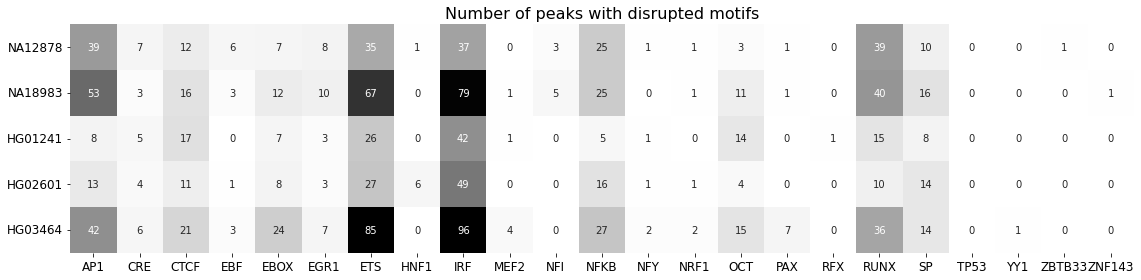

In [46]:
import seaborn as sns

plt.figure(figsize = (16, 4))
plt.title('Number of peaks with disrupted motifs', fontsize = 16)
sns.heatmap(disrupted_peaks_counts, annot = True, cbar = 0, cmap = 'Greys', vmax = 80)
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(rotation = 0, fontsize = 12)
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/chrombpnet_peaks_with_disrupted_motifs.pdf', bbox_anchors = 'tight')
plt.show()